In [1]:
#Required python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import re
import torch
import nltk
import nltk.data
from string import punctuation 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [2]:
df = pd.read_pickle('../data/raw/emotions_training.pkl')
df=df.reset_index()

In [3]:
df.head()

,index,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [5]:
df.shape

(416809, 3)

In [6]:
df['labels'] = df['emotions'].factorize()[0]
df.head()

,index,text,emotions,labels
0,27383,i feel awful about it too because it s my job ...,sadness,0
1,110083,im alone i feel awful,sadness,0
2,140764,ive probably mentioned this before but i reall...,joy,1
3,100071,i was feeling a little low few days back,sadness,0
4,2837,i beleive that i am much more sensitive to oth...,love,2


In [7]:
#importing libraries for models and nlp tasks
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sentence_transformers import SentenceTransformer


In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'], df['labels'], test_size=0.3,random_state=1)


In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [10]:
def sentence(text):
    return model.encode(text)
    

In [11]:
def bertembeddings(Xtrain,Xtest):
    Xtrain=Xtrain
    Xtest=Xtest
    
    with torch.no_grad():    


        train = Xtrain.apply(lambda x: sentence(x))
        test = Xtest.apply(lambda x: sentence(x))


    tf= [x for x in train.transpose()]
    train_features = np.asarray(tf)

    t= [x for x in test.transpose()]
    test_features = np.asarray(t)
    
    return train_features,test_features

In [12]:
train_embed,test_embed=bertembeddings(Xtrain,Xtest)

In [13]:
print(train_embed[0])

[-1.61365159e-02  2.87113041e-02  7.41750523e-02  3.15741040e-02
  1.56190423e-02 -9.07026231e-02  7.87775740e-02  1.08023779e-02
 -3.74436006e-02 -7.93367717e-03 -4.15081829e-02 -8.51694718e-02
  4.17619720e-02 -1.20245278e-01  4.20490205e-02  3.28859501e-03
  4.76417132e-02 -5.62228309e-03 -8.15045461e-02  6.50508776e-02
  1.13366907e-02  2.37985812e-02 -6.62599653e-02  2.45602857e-02
 -4.42954116e-02 -5.27194105e-02  1.06002819e-02  2.67349998e-03
 -3.35521661e-02  5.93105331e-03 -8.75631273e-02  3.53895761e-02
 -1.44208157e-02 -4.10093069e-02 -6.70723990e-02 -2.81818341e-02
  1.45987188e-02 -4.77694944e-02 -4.29150388e-02 -4.78223935e-02
 -5.47537878e-02  3.45143527e-02 -2.79172007e-02  4.43625301e-02
  3.19574811e-02 -8.20542574e-02  2.79695317e-02 -3.30830663e-02
  4.57630232e-02 -3.26388590e-02 -2.13301275e-02 -1.06884211e-01
 -8.64036474e-03 -4.06882353e-02 -5.44514367e-03  9.82210487e-02
 -7.26975650e-02 -2.36248262e-02 -1.43720768e-02 -2.93011237e-02
  8.81098397e-03  2.90620

##### Logistic Regression model

In [14]:
#Logistic Regression with multinomial
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(train_embed, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [15]:
ypred_lr_mn=lr_mn.predict(test_embed)

In [16]:
tr_acc_lr_mn = lr_mn.score(train_embed, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

70.60384006361262 70.21424629927306


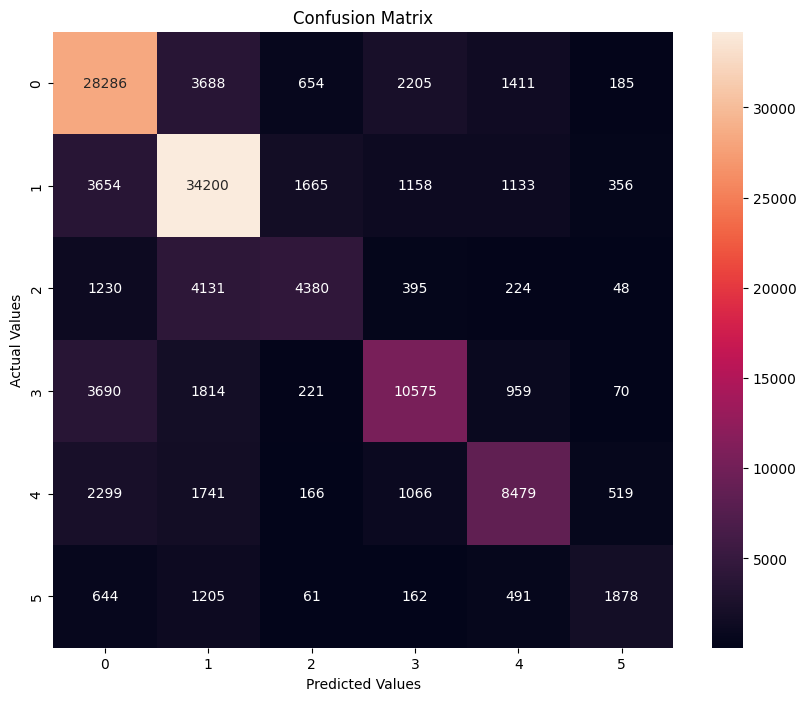

In [17]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [42]:
pickle.dump(lr_mn, open('../models/lr_mn_emotion_bert.pkl', 'wb'))

##### XGB Classifier

In [67]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 6,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)

In [68]:
eval_set = [(Xtrain_tfidf, ytrain),(Xtest_tfidf, ytest)]

In [69]:
xgb.fit(Xtrain_tfidf, ytrain, eval_metric='auc', eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.65164	validation_1-auc:0.65383
[1]	validation_0-auc:0.68139	validation_1-auc:0.68130
[2]	validation_0-auc:0.68291	validation_1-auc:0.68302
[3]	validation_0-auc:0.68556	validation_1-auc:0.68605
[4]	validation_0-auc:0.68972	validation_1-auc:0.68997


/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.70112	validation_1-auc:0.70129
[6]	validation_0-auc:0.70115	validation_1-auc:0.70105
[7]	validation_0-auc:0.70652	validation_1-auc:0.70584
[8]	validation_0-auc:0.71112	validation_1-auc:0.71100
[9]	validation_0-auc:0.71129	validation_1-auc:0.71105
[10]	validation_0-auc:0.71522	validation_1-auc:0.71497
[11]	validation_0-auc:0.72265	validation_1-auc:0.72181
[12]	validation_0-auc:0.72306	validation_1-auc:0.72116
[13]	validation_0-auc:0.72341	validation_1-auc:0.72149
[14]	validation_0-auc:0.72582	validation_1-auc:0.72408
[15]	validation_0-auc:0.73290	validation_1-auc:0.73214
[16]	validation_0-auc:0.73366	validation_1-auc:0.73245
[17]	validation_0-auc:0.73967	validation_1-auc:0.73473
[18]	validation_0-auc:0.74259	validation_1-auc:0.73641
[19]	validation_0-auc:0.74521	validation_1-auc:0.73835
[20]	validation_0-auc:0.75274	validation_1-auc:0.74605
[21]	validation_0-auc:0.75543	validation_1-auc:0.74740
[22]	validation_0-auc:0.75773	validation_1-auc:0.74988
[23]	validation

[154]	validation_0-auc:0.86094	validation_1-auc:0.82232
[155]	validation_0-auc:0.86115	validation_1-auc:0.82226
[156]	validation_0-auc:0.86139	validation_1-auc:0.82241
[157]	validation_0-auc:0.86171	validation_1-auc:0.82221
[158]	validation_0-auc:0.86201	validation_1-auc:0.82241
[159]	validation_0-auc:0.86223	validation_1-auc:0.82253
[160]	validation_0-auc:0.86252	validation_1-auc:0.82281
[161]	validation_0-auc:0.86302	validation_1-auc:0.82290
[162]	validation_0-auc:0.86333	validation_1-auc:0.82326
[163]	validation_0-auc:0.86354	validation_1-auc:0.82337
[164]	validation_0-auc:0.86385	validation_1-auc:0.82363
[165]	validation_0-auc:0.86405	validation_1-auc:0.82373
[166]	validation_0-auc:0.86412	validation_1-auc:0.82389
[167]	validation_0-auc:0.86444	validation_1-auc:0.82413
[168]	validation_0-auc:0.86481	validation_1-auc:0.82443
[169]	validation_0-auc:0.86502	validation_1-auc:0.82452
[170]	validation_0-auc:0.86516	validation_1-auc:0.82457
[171]	validation_0-auc:0.86529	validation_1-auc:

[301]	validation_0-auc:0.88914	validation_1-auc:0.83694
[302]	validation_0-auc:0.88927	validation_1-auc:0.83702
[303]	validation_0-auc:0.88945	validation_1-auc:0.83701
[304]	validation_0-auc:0.88958	validation_1-auc:0.83725
[305]	validation_0-auc:0.88970	validation_1-auc:0.83736
[306]	validation_0-auc:0.88983	validation_1-auc:0.83758
[307]	validation_0-auc:0.88993	validation_1-auc:0.83762
[308]	validation_0-auc:0.88996	validation_1-auc:0.83766
[309]	validation_0-auc:0.89009	validation_1-auc:0.83773
[310]	validation_0-auc:0.89020	validation_1-auc:0.83773
[311]	validation_0-auc:0.89029	validation_1-auc:0.83775
[312]	validation_0-auc:0.89042	validation_1-auc:0.83781
[313]	validation_0-auc:0.89067	validation_1-auc:0.83791
[314]	validation_0-auc:0.89075	validation_1-auc:0.83799
[315]	validation_0-auc:0.89088	validation_1-auc:0.83796
[316]	validation_0-auc:0.89098	validation_1-auc:0.83796
[317]	validation_0-auc:0.89113	validation_1-auc:0.83803
[318]	validation_0-auc:0.89136	validation_1-auc:

[448]	validation_0-auc:0.90540	validation_1-auc:0.84411
[449]	validation_0-auc:0.90554	validation_1-auc:0.84410
[450]	validation_0-auc:0.90565	validation_1-auc:0.84404
[451]	validation_0-auc:0.90573	validation_1-auc:0.84407
[452]	validation_0-auc:0.90581	validation_1-auc:0.84412
[453]	validation_0-auc:0.90588	validation_1-auc:0.84419
[454]	validation_0-auc:0.90598	validation_1-auc:0.84421
[455]	validation_0-auc:0.90611	validation_1-auc:0.84417
[456]	validation_0-auc:0.90623	validation_1-auc:0.84427
[457]	validation_0-auc:0.90634	validation_1-auc:0.84425
[458]	validation_0-auc:0.90644	validation_1-auc:0.84425
[459]	validation_0-auc:0.90651	validation_1-auc:0.84419
[460]	validation_0-auc:0.90661	validation_1-auc:0.84420
[461]	validation_0-auc:0.90674	validation_1-auc:0.84423
[462]	validation_0-auc:0.90683	validation_1-auc:0.84419
[463]	validation_0-auc:0.90684	validation_1-auc:0.84434
[464]	validation_0-auc:0.90689	validation_1-auc:0.84440
[465]	validation_0-auc:0.90696	validation_1-auc:

[595]	validation_0-auc:0.91733	validation_1-auc:0.84671
[596]	validation_0-auc:0.91738	validation_1-auc:0.84672
[597]	validation_0-auc:0.91746	validation_1-auc:0.84673
[598]	validation_0-auc:0.91752	validation_1-auc:0.84685
[599]	validation_0-auc:0.91756	validation_1-auc:0.84682
[600]	validation_0-auc:0.91762	validation_1-auc:0.84681
[601]	validation_0-auc:0.91768	validation_1-auc:0.84683
[602]	validation_0-auc:0.91773	validation_1-auc:0.84686
[603]	validation_0-auc:0.91787	validation_1-auc:0.84681
[604]	validation_0-auc:0.91794	validation_1-auc:0.84674
[605]	validation_0-auc:0.91801	validation_1-auc:0.84680
[606]	validation_0-auc:0.91809	validation_1-auc:0.84678
[607]	validation_0-auc:0.91817	validation_1-auc:0.84674
[608]	validation_0-auc:0.91822	validation_1-auc:0.84673
[609]	validation_0-auc:0.91828	validation_1-auc:0.84685
[610]	validation_0-auc:0.91837	validation_1-auc:0.84690
[611]	validation_0-auc:0.91846	validation_1-auc:0.84699
[612]	validation_0-auc:0.91853	validation_1-auc:

[742]	validation_0-auc:0.92635	validation_1-auc:0.84881
[743]	validation_0-auc:0.92641	validation_1-auc:0.84878
[744]	validation_0-auc:0.92647	validation_1-auc:0.84877
[745]	validation_0-auc:0.92651	validation_1-auc:0.84880
[746]	validation_0-auc:0.92654	validation_1-auc:0.84882
[747]	validation_0-auc:0.92659	validation_1-auc:0.84885
[748]	validation_0-auc:0.92666	validation_1-auc:0.84882
[749]	validation_0-auc:0.92673	validation_1-auc:0.84886
[750]	validation_0-auc:0.92678	validation_1-auc:0.84889
[751]	validation_0-auc:0.92684	validation_1-auc:0.84885
[752]	validation_0-auc:0.92691	validation_1-auc:0.84887
[753]	validation_0-auc:0.92694	validation_1-auc:0.84885
[754]	validation_0-auc:0.92699	validation_1-auc:0.84892
[755]	validation_0-auc:0.92704	validation_1-auc:0.84898
[756]	validation_0-auc:0.92709	validation_1-auc:0.84900
[757]	validation_0-auc:0.92714	validation_1-auc:0.84896
[758]	validation_0-auc:0.92718	validation_1-auc:0.84904
[759]	validation_0-auc:0.92725	validation_1-auc:

[889]	validation_0-auc:0.93353	validation_1-auc:0.84958
[890]	validation_0-auc:0.93359	validation_1-auc:0.84955
[891]	validation_0-auc:0.93364	validation_1-auc:0.84956
[892]	validation_0-auc:0.93370	validation_1-auc:0.84958
[893]	validation_0-auc:0.93372	validation_1-auc:0.84964
[894]	validation_0-auc:0.93377	validation_1-auc:0.84962
[895]	validation_0-auc:0.93380	validation_1-auc:0.84956
[896]	validation_0-auc:0.93383	validation_1-auc:0.84951
[897]	validation_0-auc:0.93388	validation_1-auc:0.84951
[898]	validation_0-auc:0.93391	validation_1-auc:0.84949
[899]	validation_0-auc:0.93396	validation_1-auc:0.84950
[900]	validation_0-auc:0.93402	validation_1-auc:0.84958
[901]	validation_0-auc:0.93406	validation_1-auc:0.84962
[902]	validation_0-auc:0.93411	validation_1-auc:0.84965
[903]	validation_0-auc:0.93417	validation_1-auc:0.84969
[904]	validation_0-auc:0.93420	validation_1-auc:0.84973
[905]	validation_0-auc:0.93427	validation_1-auc:0.84974
[906]	validation_0-auc:0.93430	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [70]:
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

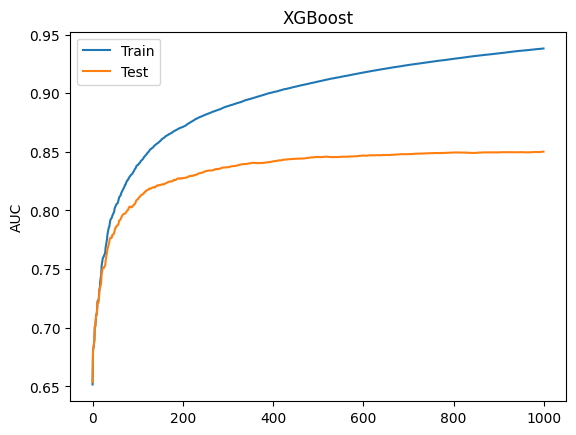

In [71]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost')
plt.show()

In [77]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)



In [78]:
%%time
xgb.fit(Xtrain_tfidf, ytrain)

CPU times: user 17.6 s, sys: 4.75 s, total: 22.3 s
Wall time: 3.44 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [79]:
ypred_xgb=xgb.predict(Xtest_tfidf)

In [80]:
tr_acc_xgb = xgb.score(Xtrain_tfidf, ytrain)*100
test_acc_xgb =  accuracy_score(ytest,ypred_xgb) * 100
print(tr_acc_xgb,test_acc_xgb)

67.31843575418995 65.98581560283688


In [81]:
pickle.dump(xgb, open('../models/xgb_basic_sentiment.pkl', 'wb'))

Tuning max_depth and min_child_weight

In [86]:
%%time
xgb_hp1=XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)



param_grid1={ 'max_depth':range(3,10,2),
              'min_child_weight':[1,2,3,4,5]}

grid_search1 = GridSearchCV(xgb_hp1, param_grid1, scoring="f1_macro", n_jobs=-1, cv=5)


grid_result1 = grid_search1.fit(Xtrain_tfidf, ytrain)

CPU times: user 27.5 s, sys: 5.92 s, total: 33.5 s
Wall time: 2min 34s


In [87]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))


Best: 0.662018 using {'max_depth': 9, 'min_child_weight': 1}


In [89]:
xgb_hp2=XGBClassifier(learning_rate =0.1, n_estimators=100,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)

param_grid2={
            'max_depth':[8,9,10]
            

}

grid_search2 = GridSearchCV(xgb_hp2, param_grid2, scoring="f1_macro", n_jobs=-1, cv=5)



In [90]:
%%time
grid_result2 = grid_search2.fit(Xtrain_tfidf, ytrain)

CPU times: user 30.5 s, sys: 5.86 s, total: 36.4 s
Wall time: 42.7 s


In [91]:
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print(grid_result2.cv_results_['mean_test_score'])

Best: 0.666677 using {'max_depth': 10}
[0.65771128 0.66201829 0.66667713]


Tuning gamma

In [92]:
xgb_hp3=XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=10,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      subsample=0.8, colsample_bytree=0.8, seed=27)

param_grid3={
 'gamma':[i/10.0 for i in range(0,5)]
}
grid_search3 = GridSearchCV(xgb_hp3, param_grid3, scoring="f1_macro", n_jobs=-1, cv=5)



In [93]:
%%time
grid_result3 = grid_search3.fit(Xtrain_tfidf, ytrain)

CPU times: user 30.4 s, sys: 6.05 s, total: 36.4 s
Wall time: 1min 22s


In [94]:
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
print(grid_result3.cv_results_['mean_test_score'])


Best: 0.666677 using {'gamma': 0.0}
[0.66667713 0.6658064  0.66639692 0.66655387 0.66535551]


Tuning subsample and colsample_bytree

In [95]:
xgb_hp4=XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=10,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0, seed=27)

param_grid4={
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grid_search4 = GridSearchCV(xgb_hp4, param_grid4, scoring="f1_macro", n_jobs=-1, cv=5)


In [96]:
%%time
grid_result4 = grid_search4.fit(Xtrain_tfidf, ytrain)

CPU times: user 30.6 s, sys: 6.02 s, total: 36.6 s
Wall time: 3min 14s


In [97]:
print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
print(grid_result4.cv_results_['mean_test_score'])


Best: 0.666677 using {'colsample_bytree': 0.8, 'subsample': 0.8}
[0.66452245 0.66462105 0.66491432 0.66517115 0.66531126 0.66539668
 0.66500449 0.66469553 0.66546151 0.6658322  0.66667713 0.66456841
 0.66559082 0.66588501 0.6650521  0.66457187]


In [98]:
param_grid4_small={
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
grid_search4_small = GridSearchCV(xgb_hp4, param_grid4_small, scoring="f1_macro", n_jobs=-1, cv=5)


In [99]:
%%time
grid_result4_small = grid_search4_small.fit(Xtrain_tfidf, ytrain)

CPU times: user 29.5 s, sys: 6.03 s, total: 35.5 s
Wall time: 2min 1s


In [100]:
print("Best: %f using %s" % (grid_result4_small.best_score_, grid_result4_small.best_params_))
print(grid_result4_small.cv_results_['mean_test_score'])


Best: 0.666940 using {'colsample_bytree': 0.75, 'subsample': 0.75}
[0.6669401  0.66600132 0.66468804 0.66679322 0.66667713 0.66570031
 0.6664064  0.66556826 0.66587638]


In [101]:
xgb_clf= XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=10,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 3,
                      gamma=0,  subsample=0.75, colsample_bytree=0.75, seed=27)

In [102]:
xgb_clf.fit(Xtrain_tfidf, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [103]:
ypred_xgb_clf=xgb_clf.predict(Xtest_tfidf)

In [104]:
tr_acc_xgb_clf = xgb_clf.score(Xtrain_tfidf, ytrain)*100
test_acc_xgb_clf =  accuracy_score(ytest,ypred_xgb_clf) * 100
print(tr_acc_xgb_clf,test_acc_xgb_clf)

72.20856610800745 68.08510638297872


In [105]:
pickle.dump(xgb_clf, open('../models/xgb_hp_sentiment.pkl', 'wb'))